# Readme

All of the data and code used here is freely available.  To execute it, you will need to install these packages:
 - IPython
 - numpy
 - matplotlib
 - chest
 - slict
 - glopen
 
I highly recommend the Python3 version of [anaconda](http://continuum.io/downloads#py34) for a nice environment.  `chest`, `slict`, and `glopen` are all [pip installable](https://pip.pypa.io/en/latest/reference/pip_install.html):
```
  pip install chest slict glopen
```

`glopen` also requires a [globus account](https://www.globus.org/) and [globus connect](https://www.globus.org/globus-connect-personal) running on the system that runs this notebook.

In [1]:
# standard imports
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 5.0)
import matplotlib.pyplot as plt
import numpy as np
import json
from functools import partial
class Foo: pass
from IPython.html.widgets import interact
from IPython.html.widgets import SelectMultiple

# custom packages.  All are pip-installable
from chest import Chest
from slict import CachedSlict
from glopen import glopen, glopen_many

# configuration
config = Foo()
#config.name     = "HighAspect/HA_conductivity_1.0E-5/HA_conductivity_1.0E-5"
#config.name2     = "Wilk/Wilk_kmin_3.5/Wilk_kmin_3.5"
#config.arch_end = "maxhutch#alpha-admin/pub/"
config.name     = "/home/maxhutch/cache/HA_conductivity_1.0E-5"
config.name2     = "/home/maxhutch/cache/Wilk_kmin_3.5"
config.arch_end = "maxhutch#edoras"

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
from matplotlib import animation
from tempfile import NamedTemporaryFile
import base64

VIDEO_TAG = """<video controls>
 <source src="data:video/x-webm;base64,{0}" type="video/webm">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.webm') as f:
            anim.save(f.name, fps=6, extra_args=['-vcodec', 'libvpx', '-pix_fmt', 'yuv420p'])
            video = open(f.name, "rb").read()
        anim._encoded_video = base64.b64encode(video).decode("utf-8")
    
    return VIDEO_TAG.format(anim._encoded_video)

from IPython.core.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

In [3]:
c = Chest(path      = "{:s}-results".format(config.name),
          open      = partial(glopen,      endpoint=config.arch_end),
          open_many = partial(glopen_many, endpoint=config.arch_end),
          available_memory = 1e12)
sc = CachedSlict(c)
with glopen(
            "{:s}.json".format(config.name), mode='r',
            endpoint = config.arch_end,
            ) as f:
    params = json.load(f)

In [4]:
wc = Chest(path      = "{:s}-results".format(config.name2),
          open      = partial(glopen,      endpoint=config.arch_end),
          open_many = partial(glopen_many, endpoint=config.arch_end),
          available_memory = 1e12)
wsc = CachedSlict(wc)
with glopen(
            "{:s}.json".format(config.name2), mode='r',
            endpoint = config.arch_end,
            ) as f:
    wparams = json.load(f)

In [5]:
# Uncomment these lines to pre-fetch from the remote server, which will take a while...
#c.prefetch(list(c.keys()))
#wc.prefetch(list(wc.keys()))

In [6]:
def plot_T(frame, zoom):
    T = sc[:,'frame'].keys()[frame]
    frame = sc[T,:]
    fig = plt.figure()
    nx = frame['t_yz'].shape[0]; ny = frame['t_yz'].shape[1]

    expanded = np.concatenate((frame['t_yz'], np.flipud(frame['t_yz'])), axis=0)

    plt.imshow(expanded[:,int(ny*(1.-zoom)/2):int(ny*(zoom/2 + .5))].transpose(), 
               origin='lower', extent=[0,1,-zoom*params["extent_mesh"][2], zoom*params["extent_mesh"][2]]);
    plt.title("Scalar @ t = {:f}".format(T));
    

def plot_TWV(frame, zoom):
    T = sc[:,'frame'].keys()[frame]
    frame = sc[T,:]
    #fig, axs = plt.subplots(1,3,sharey=True)
    nx = frame['t_yz'].shape[0]; ny = frame['t_yz'].shape[1]

    expanded_T = np.concatenate((frame['t_yz'], np.flipud(frame['t_yz'])), axis=0)
    expanded_W = np.concatenate((frame['w_yz'], np.flipud(frame['w_yz'])), axis=0)
    expanded_V = np.concatenate((frame['vorticity_yz'], -np.flipud(frame['vorticity_yz'])), axis=0)

    axs[0].imshow(expanded_T[:,int(ny*(1.-zoom)/2):int(ny*(zoom/2 + .5))].transpose(), 
               origin='lower', extent=[0,1,-zoom*params["extent_mesh"][2], zoom*params["extent_mesh"][2]]);
    axs[0].set_title("Temperature");
    axs[1].imshow(expanded_W[:,int(ny*(1.-zoom)/2):int(ny*(zoom/2 + .5))].transpose(), 
               origin='lower', extent=[0,1,-zoom*params["extent_mesh"][2], zoom*params["extent_mesh"][2]]);
    axs[1].set_title("Velocity (z)".format(T));
    axs[2].imshow(expanded_V[:,int(ny*(1.-zoom)/2):int(ny*(zoom/2 + .5))].transpose(), 
               origin='lower', extent=[0,1,-zoom*params["extent_mesh"][2], zoom*params["extent_mesh"][2]]);
    axs[2].set_title("Vorticity".format(T));
    
def plot_TWV_span(frame):
    T = sc[:,'frame'].keys()[frame]
    frame = sc[T,:]
    #fig, axs = plt.subplots(2,2,figsize=(16,8))
    nx = frame['t_xy'].shape[0]; ny = frame['t_xy'].shape[1]

    expanded_T = np.concatenate((frame['t_xy'], np.flipud(frame['t_xy']), frame['t_xy'], np.flipud(frame['t_xy'])), axis=0)
    expanded_T = np.concatenate((expanded_T, np.fliplr(expanded_T)), axis=1)
    
    expanded_W = np.concatenate((frame['w_xy'], np.flipud(frame['w_xy']), frame['w_xy'], np.flipud(frame['w_xy'])), axis=0)
    expanded_W = np.concatenate((expanded_W, np.fliplr(expanded_W)), axis=1)
    
    expanded_V = np.concatenate((frame['vorticity_xy'], -np.flipud(frame['vorticity_xy']), frame['vorticity_xy'], -np.flipud(frame['vorticity_xy'])), axis=0)
    expanded_V = np.concatenate((expanded_V, -np.fliplr(expanded_V)), axis=1)
    
    axs[0][0].imshow(expanded_T.transpose(), 
               origin='lower', extent=[0,2,0,1]);
    axs[0][0].set_title("Scalar @ t = {:f}".format(T));
    axs[0][1].imshow(expanded_W.transpose(), 
               origin='lower', extent=[0,2,0,1]);
    axs[0][1].set_title("Velocity (z) @ t = {:f}".format(T));
    axs[1][0].imshow(expanded_V.transpose(), 
               origin='lower', extent=[0,2,0,1]);
    axs[1][0].set_title("Vorticity @ t = {:f}".format(T));

def plot_TWVP_span(frame):
    T = sc[:,'frame'].keys()[frame]
    frame = sc[T,:]
    #fig, axs = plt.subplots(2,2,figsize=(16,8))
    nx = frame['t_xy'].shape[0]; ny = frame['t_xy'].shape[1]

    expanded_T = np.concatenate((frame['t_xy'], np.flipud(frame['t_xy']), frame['t_xy'], np.flipud(frame['t_xy'])), axis=0)
    expanded_T = np.concatenate((expanded_T, np.fliplr(expanded_T)), axis=1)
    
    expanded_W = np.concatenate((frame['w_xy'], np.flipud(frame['w_xy']), frame['w_xy'], np.flipud(frame['w_xy'])), axis=0)
    expanded_W = np.concatenate((expanded_W, np.fliplr(expanded_W)), axis=1)
    
    expanded_V = np.concatenate((frame['vorticity_xy'], -np.flipud(frame['vorticity_xy']), frame['vorticity_xy'], -np.flipud(frame['vorticity_xy'])), axis=0)
    expanded_V = np.concatenate((expanded_V, -np.fliplr(expanded_V)), axis=1)
    
    expanded_P = np.concatenate((frame['p_xy'], np.flipud(frame['p_xy']), frame['p_xy'], np.flipud(frame['p_xy'])), axis=0)
    expanded_P = np.concatenate((expanded_P, np.fliplr(expanded_P)), axis=1)
    axs[0][0].imshow(expanded_T.transpose(), 
               origin='lower', extent=[0,2,0,1]);
    axs[0][0].set_title("Scalar @ t = {:f}".format(T));
    axs[0][1].imshow(expanded_W.transpose(), 
               origin='lower', extent=[0,2,0,1]);
    axs[0][1].set_title("Velocity (z) @ t = {:f}".format(T));
    axs[1][0].imshow(expanded_V.transpose(), 
               origin='lower', extent=[0,2,0,1]);
    axs[1][0].set_title("Vorticity @ t = {:f}".format(T));
    axs[1][1].imshow(expanded_P.transpose(), 
               origin='lower', extent=[0,2,0,1]);
    axs[1][1].set_title("Pressure @ t = {:f}".format(T));

def plot_wilk(frame):
    T = wsc[:,'frame'].keys()[frame]
    frame = wsc[T,:]
    #fig, axs = plt.subplots(1,3,sharey=True)
    nx = frame['t_yz'].shape[0]; ny = frame['t_yz'].shape[1]

    expanded_T = frame['t_yz']
    expanded_W = frame['w_yz']

    axs[0].imshow(expanded_T.transpose(), 
               origin='lower', extent=[0,1,-1,1]);
    axs[0].set_title("Temperature");
    axs[1].imshow(expanded_W.transpose(), 
               origin='lower', extent=[0,1,-1,1]);
    axs[1].set_title("Velocity (z)");
    
def plot_wilk_span(frame):
    T = wsc[:,'frame'].keys()[frame]
    frame = wsc[T,:]
    #fig, axs = plt.subplots(2,2,figsize=(16,12))
    nx = frame['t_xy'].shape[0]; ny = frame['t_xy'].shape[1]

    expanded_T = frame['t_xy']
    expanded_W = frame['w_xy']
    expanded_V = frame['vorticity_xy']
    expanded_P = frame['p_xy']

    font_size = 20;
    axs[0][0].imshow(expanded_T.transpose(), 
               origin='lower', extent=[0,1,0,1]);
    axs[0][0].set_title("Scalar", fontsize=font_size);
    axs[0][1].imshow(expanded_W.transpose(), 
               origin='lower', extent=[0,1,0,1]);
    axs[0][1].set_title("Velocity (z)", fontsize=font_size);
    axs[1][0].imshow(expanded_V.transpose(), 
               origin='lower', extent=[0,1,0,1]);
    axs[1][0].set_title("Vorticity", fontsize=font_size);
    axs[1][1].imshow(expanded_P.transpose(), 
               origin='lower', extent=[0,1,0,1]);
    axs[1][1].set_title("Pressure", fontsize=font_size);

# Exploring the parameter space of the late-time Rayleigh-Taylor instability
&nbsp;
### Max Hutchinson
### University of Chicago

&nbsp;

### CSGF program review, July 29th, 2015

# Experimental validation of direct numerical simulation of the single-mode Rayleigh Taylor instability
&nbsp;
### Max Hutchinson
### University of Chicago

&nbsp;

### CSGF program review, July 29th, 2015

## Acknowledgements
 - Department of Energy Computational Science Graduate Fellowship
 - Argonne Leadership Computing Challenge
 - Robert Rosner
 - Nek5000 developers: Paul Fischer, Aleks Obabko, James Lottes, Katie Heisey, Oana Marin, Ananias Tomboulides

Good afternoon.  My name is Max Hutchinson and we are going to be talking about the late-time dynamics of the Rayleigh-Taylor instability.

## Outline
 - Rayleigh-Taylor instability
   - Motivation
   - Boussinesq approximation
   - Single-mode simplification
 - Comparison to experiment ([Wilkinson and Jacobs 2007](http://scitation.aip.org/content/aip/journal/pof2/19/12/10.1063/1.2813548))
   - Validation of simulation
   - Interpolation: secondary flow
   - Extrapolation: late-time dynamics
 - Conclusions

# Rayleigh-Taylor instability (RTI)

The Rayleigh-Taylor instability occurs when pressure and density gradients oppose:

$$ (\mathbf{\nabla} P) \cdot (\mathbf{\nabla} \rho) < 0 $$

 - Dense fluid above light fluid in gravity (reactor)
 - Light fluid around dense fluid in explosion (supernova)
 - Dense fluid around light fluid in implosion (fusion)

## Topics limited by single-mode RTI understanding
 - What is the safe operating envelope of a reactor
 - How do we achieve inertial confinement fusion ignition
 - How does mixing in core collapse supernovae occur
 - What is the fine structure of oceanic salinity and thermal structures
 - What is the self-similar RTI growth rate

## State of the theory

We know:
 - Linear (Duff, 1962) and weakly non-linear theories for early times
 - Potential flow when the density difference is very large (Layzer 1955), ([Goncharov 2002](http://journals.aps.org/prl/abstract/10.1103/PhysRevLett.88.134502))
 
We don't know:
 - Moderate and late-time theories ([Ramaprabhu 2012](http://scitation.aip.org/content/aip/journal/pof2/24/7/10.1063/1.4733396)) and ([Wei 2012](http://journals.aps.org/pre/abstract/10.1103/PhysRevE.86.046405))
 
Only experiments and simulation can access late-time behavior

## Governing equations

The Boussinesq approximation yields single fluid with active scalar:

\begin{align} 
\left[\frac{\partial}{\partial t} + \mathbf{u} \cdot \mathbf{\nabla}\right] \mathbf{u} &= \nu \nabla^2 \mathbf{u} - \mathbf{\nabla} P + A \mathbf{g} \phi \\
\left[\frac{\partial}{\partial t} + \mathbf{u} \cdot \mathbf{\nabla}\right] \phi &= D \nabla^2 \phi 
\end{align}

## Single mode RTI

Consider a heavy fluid above a light fluid with a plane interface perturbed by a single wavenumber $\vec{k}$.
\begin{multline} \phi(x,y,z,0) = \text{erf}\left[ \frac{z + a_0 \cos(k_x x) \cos(k_y y)}{ \delta }\right] 
\end{multline}

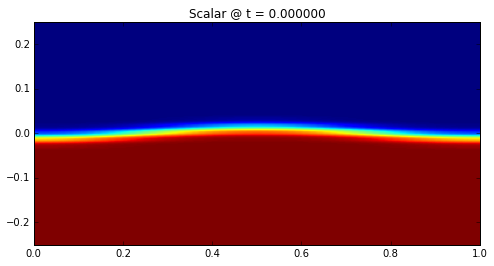

In [7]:
plot_T(0, .0625)

## A Typical Result
  - $ \text{Grashof} = A g \lambda^3 / (\nu^2) = 9.8 \times 10^{4} $
  - $ \text{Schmidt} = \nu/D = 10 $

In [8]:
fig, axs = plt.subplots(1,3,sharey=True)
display_animation(animation.FuncAnimation(fig, partial(plot_TWV, zoom=.5), frames=100, interval=1000, blit=False))

# Direct comparison to experiment

![](figs/WilkJacobsHeader.png)


| <img src="http://scitation.aip.org/docserver/fulltext/aip/journal/pof2/19/12/1.2813548.online.f1.gif" width=300> | <img src="http://scitation.aip.org/docserver/fulltext/aip/journal/pof2/19/12/1.2813548.online.f2.gif"> | <img src="http://scitation.aip.org/docserver/fulltext/aip/journal/pof2/19/12/1.2813548.online.f6.gif" width=300> |
| --- | --- | --- |
| Rig | Tank | Example PLIF | 

## Details

We replicated three runs from Wilkinson and Jacobs (2007):

\begin{multline}
\phi(x,y,z,0) =\\ \text{erf}\left[ \frac{z + (1.1) \cos\left( (0.10) \frac{x+y}{2}\right) \cos\left( (0.10) \frac{x-y}{2}\right)}{ 1.4}\right] 
\end{multline}

For

$$ (x,y,z) \in \left[0, 76\right]^2 \times \left[-76, 76 \right] $$

(all lengths in millimeters)

For CSGF-ers
 - 3.4 B grid points, 67 M elements, 5 fields
 - 1.5 s per step on 512K cores, 3 M core-hours each
 - Grashof: 5 M, Rayleigh: 35 M 

In [9]:
fig, axs = plt.subplots(1,2,figsize=(8,8))
display_animation(animation.FuncAnimation(fig, partial(plot_wilk), frames=64, interval=1000, blit=False))

## Validation of simulation

If the parameter spaces and observables of the experiment and computation overlap, then we can use the experimental results to validate the computation.

Matched:
 - Reynolds number
 - Boundary, initial conditions
 
Unmatched:
 - Schmidt number
 - Density, viscosity asymmetry

The summary plot is the non-dimensional velocity (Fr) vs the non-dimensional height ($h / \lambda$).
<img; src=figs/wilkinson_Fr.png width=600>

We've picked out the experimental points that correspond to our initial conditions.
<img; src=figs/Figure17.png width=600>
https://github.com/maxhutch/thesis-notebooks/WilkinsonAndJacobs.ipynb

## Interpolation: secondary flow
One advantage of simulations is their exposure of the full physical fields, not the sparse set of observables found in experiments.

Without much marginal effort, we can explore the data to find new phenomena.

Here are slices of the fields through the mid-plane:

In [10]:
fig, axs = plt.subplots(2,2,figsize=(12,9))
anim = animation.FuncAnimation(fig, partial(plot_wilk_span), frames=64, interval=1000, blit=False)
display_animation(anim)

This is secondary flow of the first kind, which enhances mixing **at low Reynolds number**.

## Extrapolation: late time dynamics

Another advantage of simulations is their flexibility.

We can try things in simulations that would be too costly/difficult/time-consuming to try experimentally.
The marginal cost is mostly computer, not scientist, time.

What if the rig was 4x as tall?
 - The calculation is 4x more expensive, but uses all the same code

We extend the velocity vs height plot from before.
<img; src=figs/Figure17_long.png width=600>
https://github.com/maxhutch/thesis-notebooks/WilkinsonAndJacobs.ipynb

It appears that the bubble keeps accelerating, counter to existing theories that predict stagnation.

# Conclusions

 - Direct numerical simulations agree with single-mode lab experiments
   - Boussinesq can be corrected for by the theory
   
 - Access to full-field data reveals new span-wise flows
   - Secondary flows of the first kind
   - Could enhance mixing at low Reynolds number
   
 - Higher aspect ratio simulations are easy
   - But they run into aforementioned wall-related issues
   - High aspect simulations should stick to periodic boundary conditions

# Thank you
# Questions

![](http://grad.berkeley.edu/wp-content/uploads/CSGF_Horz_Logo.1.jpg)

https://github.com/maxhutch/rti-talks/blob/master/FinalTalkCSGF.ipynb

In [11]:
%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py 
%load_ext version_information 
%version_information numpy, matplotlib, slict, chest, glopen, globussh

Installed version_information.py. To use it, type:
  %load_ext version_information


Software versions
Python 3.4.3 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 3.2.0
OS Linux 3.16.0 4 amd64 x86_64 with debian 8.1
numpy 1.10.0.dev0+00f4fae
matplotlib 1.4.3
slict 0.2.5
chest 0.2.2
glopen 0.0.12
globussh 0.1.1
Wed Jul 29 07:59:26 2015 CDT

## Validation of experiment to model

Just as we validate the simulation by the experiment, we can validate the experimental assumptions by the model.

The experiment is trying to study the single-mode RTI.
It deviates from that model in a big way: single mode RTI has periodic boundaries but the experiment has walls.

It is not clear what effects the walls will have on the single-mode dynamics.

Using our access to off-diagonal data, we can look at the bubble height as a function of distance from the wall.
We can also simulate and compare to the model periodic case.

Don't have this plot yet!

# CFD scaling laws

The total cost for direct numerical simulation with semi-implicit time-steppers:
$$ f(\text{Re}, \text{Pr}) \sim \left(\max[1, \text{Pr}] \text{Re}\right)^4 $$
with a pre-factor of $\approx 10^{-10}$ Mira core-hours.

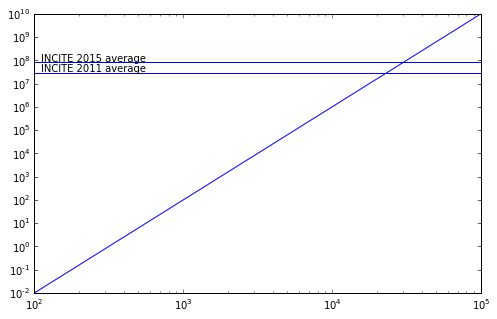

In [12]:
plt.plot(np.logspace(2,5),np.logspace(2,5)**4 / 1e10);
plt.xscale('log');
plt.yscale('log');
plt.axhline(85e6); plt.text(110,85e6*1.1,"INCITE 2015 average");
plt.axhline(30e6); plt.text(110,30e6*1.1,"INCITE 2011 average");

| <img src="figs/throughput.png" width=800> | <img src="figs/mem.png" width=800> |
| --- | --- | 
| <img src="figs/io.png" width=800> | <img src="figs/init.png" width=800> |